<a href="https://colab.research.google.com/github/OmarAlsaqa/agenderace/blob/master/AgeGenderRace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!tar -xf "/content/drive/My Drive/UTKFace.tar.gz"

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
DATA_DIR = "/content/UTKFace"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'female': 1, 'male': 0},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'asian': 2, 'black': 1, 'indian': 3, 'others': 4, 'white': 0})

In [0]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [0]:
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))

In [0]:
attributes = list(map(parse_filepath, files))

/content/UTKFace/61_1_20170109150557335.jpg.chip.jpg
/content/UTKFace/61_1_20170109142408075.jpg.chip.jpg
/content/UTKFace/39_1_20170116174525125.jpg.chip.jpg


In [0]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df.head()

,age,gender,race,file
0,13.0,female,others,/content/UTKFace/13_1_4_20170104005210478.jpg....
1,26.0,male,white,/content/UTKFace/26_0_0_20170116232725357.jpg....
2,29.0,male,black,/content/UTKFace/29_0_1_20170117022120994.jpg....
3,30.0,male,black,/content/UTKFace/30_0_1_20170117123839619.jpg....
4,40.0,male,white,/content/UTKFace/40_0_0_20170116221901075.jpg....


In [0]:
df.describe()

,age
count,23705.000000
mean,33.300907
std,19.885708
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


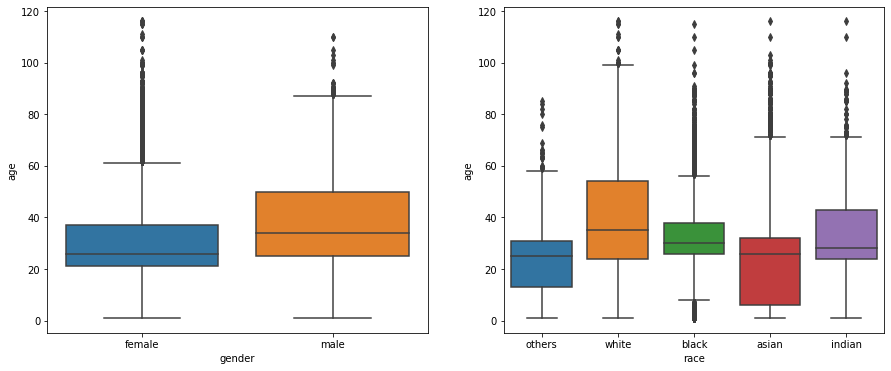

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

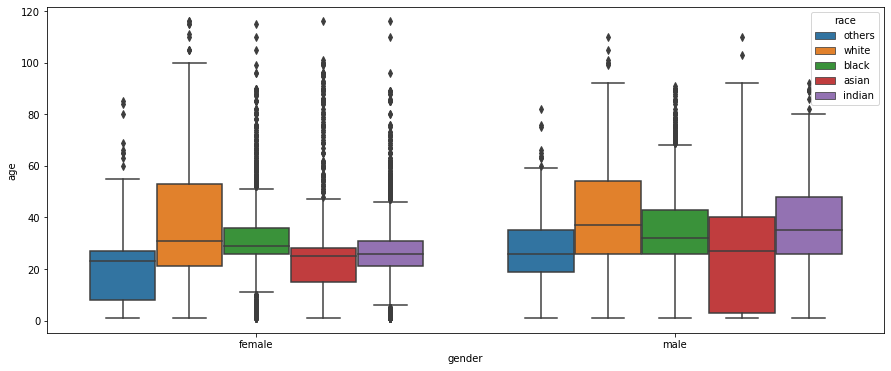

In [0]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='gender', y='age', hue='race')

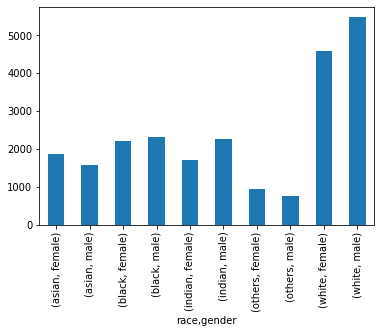

In [0]:
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')

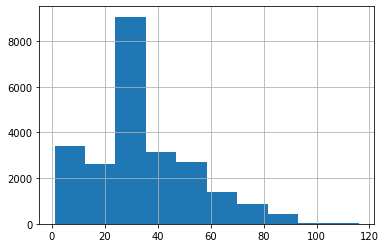

In [0]:
df['age'].hist()

In [0]:
df['age'].describe()

count    23705.000000
mean        33.300907
std         19.885708
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64

In [0]:
df = df[(df['age'] > 10) & (df['age'] < 65)]

In [0]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age

(9079, 3891, 5559, 64.0)

In [0]:
from keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

Using TensorFlow backend.


In [0]:
!pip install tensorflow==1.14

     |▎                               | 921kB 2.7MB/s eta 0:00:40
ERROR: Operation cancelled by user


In [0]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.optimizers import SGD
from keras.models import Model

def conv_block(inp, filters=16, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
_ = conv_block(input_layer, filters=16, bn=False, pool=False)
_ = conv_block(_, filters=16*2)
_ = conv_block(_, filters=16*3)
_ = conv_block(_, filters=16*4)
_ = conv_block(_, filters=16*5)
_ = conv_block(_, filters=16*6)
bottleneck = GlobalMaxPool2D()(_)

age_output = Dropout(0.3)(bottleneck)
race_output = Dropout(0.5)(bottleneck)
gender_output = Dropout(0.4)(bottleneck)

# for age calculation
_ = Dense(units=64, activation='relu')(age_output)
age_output = Dense(units=1, activation='hard_sigmoid', name='age_output')(_)


# for race prediction
_ = Dense(units=64, activation='relu')(race_output)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(_)


# for gender prediction
_ = Dense(units=64, activation='relu')(gender_output)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(_)



model = Model(inputs=input_layer, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop', 
              loss={'age_output': 'mse', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'mae', 'race_output': 'accuracy', 'gender_output': 'accuracy'})
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 198, 198, 3)  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 196, 196, 16) 448         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 194, 194, 32) 4640        conv2d_31[0][0]                  
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 194, 194, 32) 128         conv2d_32[0][0]                  
____________________________________________________________________________________________

In [0]:

batch_size = 32
valid_batch_size = 32
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)


history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=10,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/10
283/283 [==============================] - 84s 297ms/step - loss: 3.4362 - age_output_loss: 0.0605 - race_output_loss: 1.6820 - gender_output_loss: 0.7922 - age_output_mae: 0.1939 - race_output_accuracy: 0.3950 - gender_output_accuracy: 0.5955 - val_loss: 3.6242 - val_age_output_loss: 0.0375 - val_race_output_loss: 1.6743 - val_gender_output_loss: 0.7595 - val_age_output_mae: 0.1627 - val_race_output_accuracy: 0.4101 - val_gender_output_accuracy: 0.5395
Epoch 2/10
283/283 [==============================] - 81s 286ms/step - loss: 2.6556 - age_output_loss: 0.0384 - race_output_loss: 1.3562 - gender_output_loss: 0.5445 - age_output_mae: 0.1561 - race_output_accuracy: 0.4675 - gender_output_accuracy: 0.7271 - val_loss: 2.5354 - val_age_output_loss: 0.0402 - val_race_output_loss: 1.3487 - val_gender_output_loss: 0.4384 - val_age_output_mae: 0.1466 - val_race_output_accuracy: 0.4974 - val_gender_output_accuracy: 0.8184
Epoch 3/10
283/283 [==============================] - 81s 286m

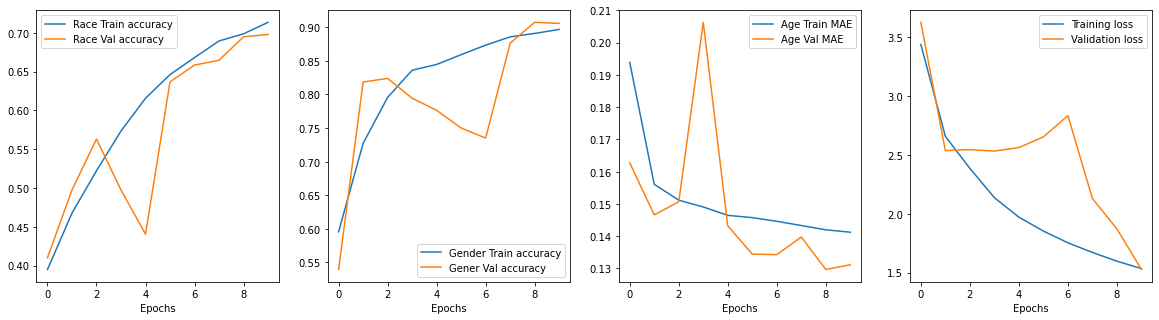

In [0]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_mae'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_mae'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

In [0]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

{'age_output_loss': 0.02963368594646454,
 'age_output_mae': 0.13478253781795502,
 'gender_output_accuracy': 0.9080668687820435,
 'gender_output_loss': 0.23596467077732086,
 'loss': 1.4313477277755737,
 'race_output_accuracy': 0.7054868936538696,
 'race_output_loss': 0.8521324992179871}

In [0]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=64)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

In [0]:
race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age

In [0]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.71      0.93      0.81        27
           1       0.88      0.64      0.74        11
           2       0.60      0.60      0.60         5
           3       0.77      0.71      0.74        14
           4       0.67      0.29      0.40         7

    accuracy                           0.73        64
   macro avg       0.73      0.63      0.66        64
weighted avg       0.74      0.73      0.72        64


Classification report for gender
              precision    recall  f1-score   support

           0       0.96      0.89      0.92        27
           1       0.92      0.97      0.95        37

    accuracy                           0.94        64
   macro avg       0.94      0.93      0.94        64
weighted avg       0.94      0.94      0.94        64



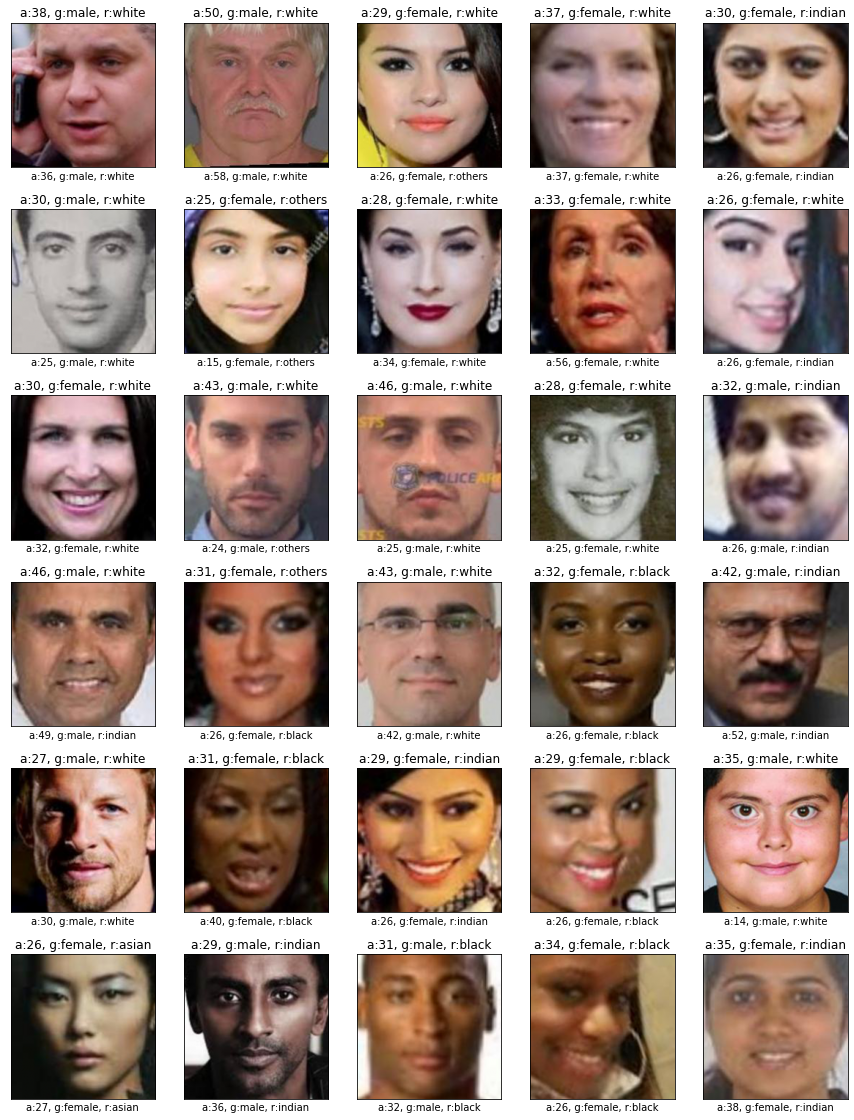

In [0]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('a:{}, g:{}, r:{}'.format(int(age_pred[img_idx]), ID_GENDER_MAP[gender_pred[img_idx]], ID_RACE_MAP[race_pred[img_idx]]))
    ax.set_xlabel('a:{}, g:{}, r:{}'.format(int(age_true[img_idx]), ID_GENDER_MAP[gender_true[img_idx]], ID_RACE_MAP[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])

In [0]:
model_name = 'AGR_2nd.h5'
save_dir = '/content/drive/My Drive/'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/AGR_2nd.h5 
